In [246]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import imblearn 
import random 
import warnings 
warnings.filterwarnings('ignore')

from imblearn.over_sampling import SVMSMOTE
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

### Basis: The number of samples <code>m = 62</code> is greater than the number of features <code>n = 2</code>.

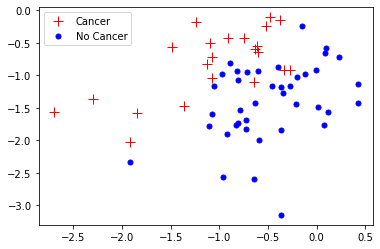

In [185]:
df_colon = pd.read_csv('../data/colon.csv')
XX = df_colon[['T62947', 'H64807']]
yy = df_colon['Class']
X, y = XX.to_numpy(), yy.to_numpy()
y = y.flatten()
class1 = (y ==  1)
class2 = (y == -1)
plt.figure(figsize = (6, 4))
plt.plot(X[:,0][class1], X[:,1][class1], "r+", markersize = 10, label = 'Cancer')
plt.plot(X[:,0][class2], X[:,1][class2], "b.", markersize = 10, label = 'No Cancer')
plt.legend()

# oversample = SVMSMOTE()
# X, y = oversample.fit_resample(X, y)

In [231]:
random.seed(413)

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

tuned_parameters = [{'kernel': ['rbf'],     'gamma': [1e-2, 1e-3, 1e-4, 1e-5], 'C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]},
                    {'kernel': ['sigmoid'], 'gamma': [1e-2, 1e-3, 1e-4, 1e-5], 'C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]},
                    {'kernel': ['linear'],                                     'C': [0.001, 0.10, 0.1, 10, 20, 25, 50, 100, 1000]}]

scores = ['precision', 'recall']
for score in scores:
    clf = GridSearchCV(SVC(C = 1), tuned_parameters, cv = 10,
    scoring='%s_macro' % score)
    clf.fit(X_train, y_train)

print('Best parameters set found on development set:')
print(clf.best_params_)
means = clf.cv_results_['mean_test_score']
stds  = clf.cv_results_['std_test_score']

Best parameters set found on development set:
{'C': 50, 'gamma': 1e-05, 'kernel': 'rbf'}


In [233]:
random.seed(413)
svclassifier = SVC(kernel = 'sigmoid', C = 50, gamma = 0.00001)
svclassifier.fit(X_train, y_train)

y_pred = svclassifier.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[7 1]
 [0 5]]
              precision    recall  f1-score   support

          -1       1.00      0.88      0.93         8
           1       0.83      1.00      0.91         5

    accuracy                           0.92        13
   macro avg       0.92      0.94      0.92        13
weighted avg       0.94      0.92      0.92        13



[LibSVM]

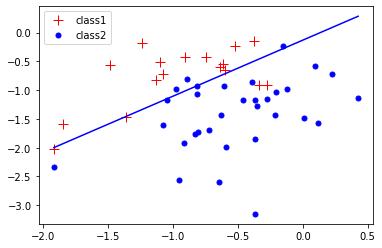

In [184]:
def svmTrainLinear(X, y, C, kernelFunction, tol=1e-3, max_passes=-1, sigma=0.1):
    y = y.flatten()
    clf = svm.SVC(C = C, kernel=kernelFunction, tol=tol, max_iter=max_passes, verbose=2)
    return clf.fit(X, y)       

def plotData(X, y):
    y = y.flatten()
    class1 = (y ==  1)
    class2 = (y == -1)
    plt.figure(figsize=(6,4))    
    plt.plot(X[:,0][class1], X[:,1][class1], "r+", markersize = 10, label='class1')
    plt.plot(X[:,0][class2], X[:,1][class2], "b.", markersize = 10, label='class2')
    plt.legend()
       
def visualizeBoundaryLinear(X, y, model):
    plotData(X, y) 
    w = model.coef_[0]
    b = model.intercept_[0]
    xp = np.linspace(X[:,0].min(), X[:,0].max(), 100)
    yp = - (w[0] * xp + b) / w[1]
    plt.plot(xp, yp, 'b-')   
    plt.show()

C = 100
linear_model = svmTrainLinear(X, y, C, "linear")
visualizeBoundaryLinear(X_train, y_train, linear_model)

<Figure size 720x576 with 0 Axes>

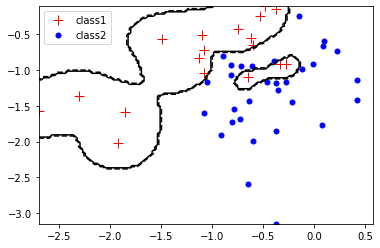

In [90]:
def visualizeBoundaryNonLinear(X, y, model):
    plt.figure(figsize=(10,8))
    plotData(X, y)
    X_21,X_22 = np.meshgrid(np.linspace(X[:,0].min(),X[:,1].max(),num = 100),np.linspace(X[:,1].min(),X[:,1].max(),num=100))
    plt.contour(X_21, X_22, rbk_model.predict(np.array([X_21.ravel(),X_22.ravel()]).T).reshape(X_21.shape), 1, colors = 'k')
    plt.legend()
    plt.show()
    
rbk_model = SVC(kernel = 'rbf', gamma = 10, C = 100)
rbk_model.fit(X_train, y_train.ravel())
visualizeBoundaryNonLinear(X_train, y_train, rbk_model)

## Section 3 
#### Train a SVM-model by using colon-data set and tuning the hyper-parameters, and select the best model. <code>(Training:Testing = 80:20)</code> and give your comments

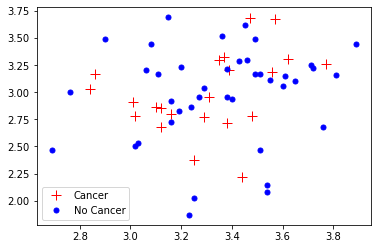

In [236]:
XX = df_colon.drop('Class', axis = 1)
yy = df_colon['Class']

X, y = XX.to_numpy(), yy.to_numpy()
y = y.flatten()

plt.figure(figsize = (6, 4))
plt.plot(X[:,0][class1], X[:,1][y ==  1], "r+", markersize = 10, label = 'Cancer')
plt.plot(X[:,0][class2], X[:,1][y == -1], "b.", markersize = 10, label = 'No Cancer')
plt.legend()

In [241]:
random.seed(413)
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

tuned_parameters = [{'kernel': ['rbf'],     'gamma': [1e-2, 1e-3, 1e-4, 1e-5], 'C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]},
                    {'kernel': ['sigmoid'], 'gamma': [1e-2, 1e-3, 1e-4, 1e-5], 'C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]},
                    {'kernel': ['linear'],  'C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]}]

scoring = {
    'Precision': 'precision',
    'Recall': 'recall',
    'Accuracy': 'accuracy',
    'AUC': 'roc_auc',
    'F1': 'f1_micro'}
    
random.seed(413)
clf = GridSearchCV(
              SVC(), param_grid = tuned_parameters,
              scoring = scoring, refit = 'Recall',
              return_train_score = True)
clf.fit(X_train, y_train)
results = clf.cv_results_

print('Best parameters set found on development set:')
print(clf.best_params_)

Best parameters set found on development set:
{'C': 50, 'gamma': 1e-05, 'kernel': 'rbf'}


In [245]:
random.seed(413)
svclassifier = SVC(kernel = 'rbf', C = 50, gamma = 0.00001)
svclassifier.fit(X_train, y_train)

y_pred = svclassifier.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[9 1]
 [1 2]]
              precision    recall  f1-score   support

          -1       0.90      0.90      0.90        10
           1       0.67      0.67      0.67         3

    accuracy                           0.85        13
   macro avg       0.78      0.78      0.78        13
weighted avg       0.85      0.85      0.85        13

